## Run these cells before running the actual colab notebook

(Uncomment and run these cells)

In [42]:
#!git clone https://github.com/ManavMNair/Quantum-image-encryption.git


In [43]:
#%cd Quantum-image-encryption

In [44]:


#!pip install -r requirements.txt

In [45]:
#!pip install pylatexenc

## Imports

In [46]:
import sys
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from quantum.neqr import encode_neqr, reconstruct_neqr_image
#----------------------------------------------------------------------------------------------------------------
# Uncomment and Call these functions for encoding with MCQI. The reconstruction quality is depends on the shot count. 
# As the shot count increases SSIM increases. But significantly lower reconstruction quality compared to NEQR's
# from quantum.mcqi import encode_mcqi, reconstruct_mcqi_image
#----------------------------------------------------------------------------------------------------------------

from quantum.scrambling import (
    quantum_scramble,
    quantum_permutation,
    reverse_quantum_scrambling,
    reverse_quantum_permutation
)

from chaos.qrng import qrng
from chaos.henon import henon_map
from chaos.hybrid_map import generate_chaotic_key_image

from dna.dna_encode import dna_encode
from dna.dna_decode import dna_decrypt

from utils.metrics import compute_psnr_ssim


## Configuration Parameters

In [62]:
IMAGE_PATH = "data/Te-gl_0017.png"
IMG_SIZE = 16
BLOCK_SIZE = 8
SHOTS = 65536
SEED_BITS = 16

## Load and display original image

Original Resolution: 512 x 512


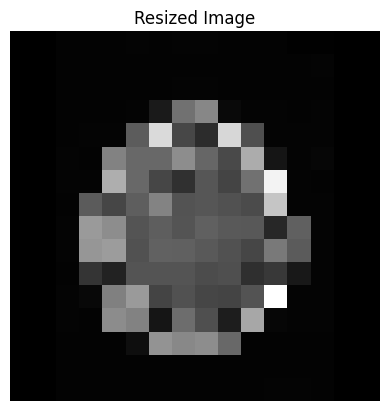

Image shape: (16, 16)


In [63]:
img = cv.imread(IMAGE_PATH, cv.IMREAD_GRAYSCALE)
height, width = img.shape[:2]
print(f"Original Resolution: {width} x {height}")

img = cv.resize(img, (IMG_SIZE, IMG_SIZE))
img = img.astype(np.uint8)

plt.imshow(img, cmap="gray")
plt.title("Resized Image")
plt.axis("off")
plt.show()

print("Image shape:", img.shape)


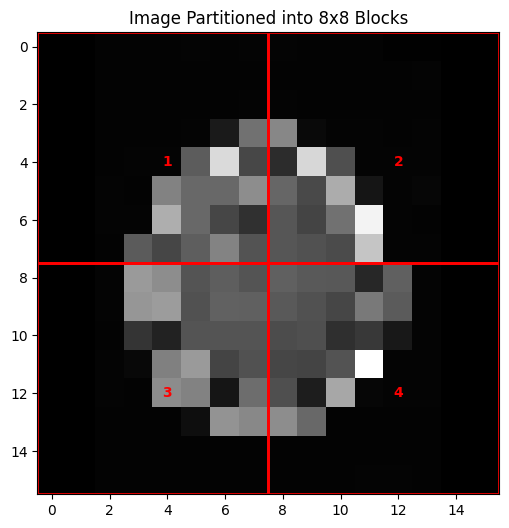

In [64]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img, cmap='gray')

# Draw the grid lines representing the slices
for y in range(0, IMG_SIZE, BLOCK_SIZE):
    for x in range(0, IMG_SIZE, BLOCK_SIZE):
        # Create a rectangle patch for each block
        rect = patches.Rectangle((x - 0.5, y - 0.5), BLOCK_SIZE, BLOCK_SIZE, 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # Optional: Label the blocks by their index (k)
        block_idx = (y // BLOCK_SIZE) * (IMG_SIZE // BLOCK_SIZE) + (x // BLOCK_SIZE) + 1
        ax.text(x + BLOCK_SIZE/2, y + BLOCK_SIZE/2, str(block_idx), 
                color='red', ha='center', va='center', fontweight='bold')

plt.title(f"Image Partitioned into {BLOCK_SIZE}x{BLOCK_SIZE} Blocks")
plt.axis('on')
plt.show()

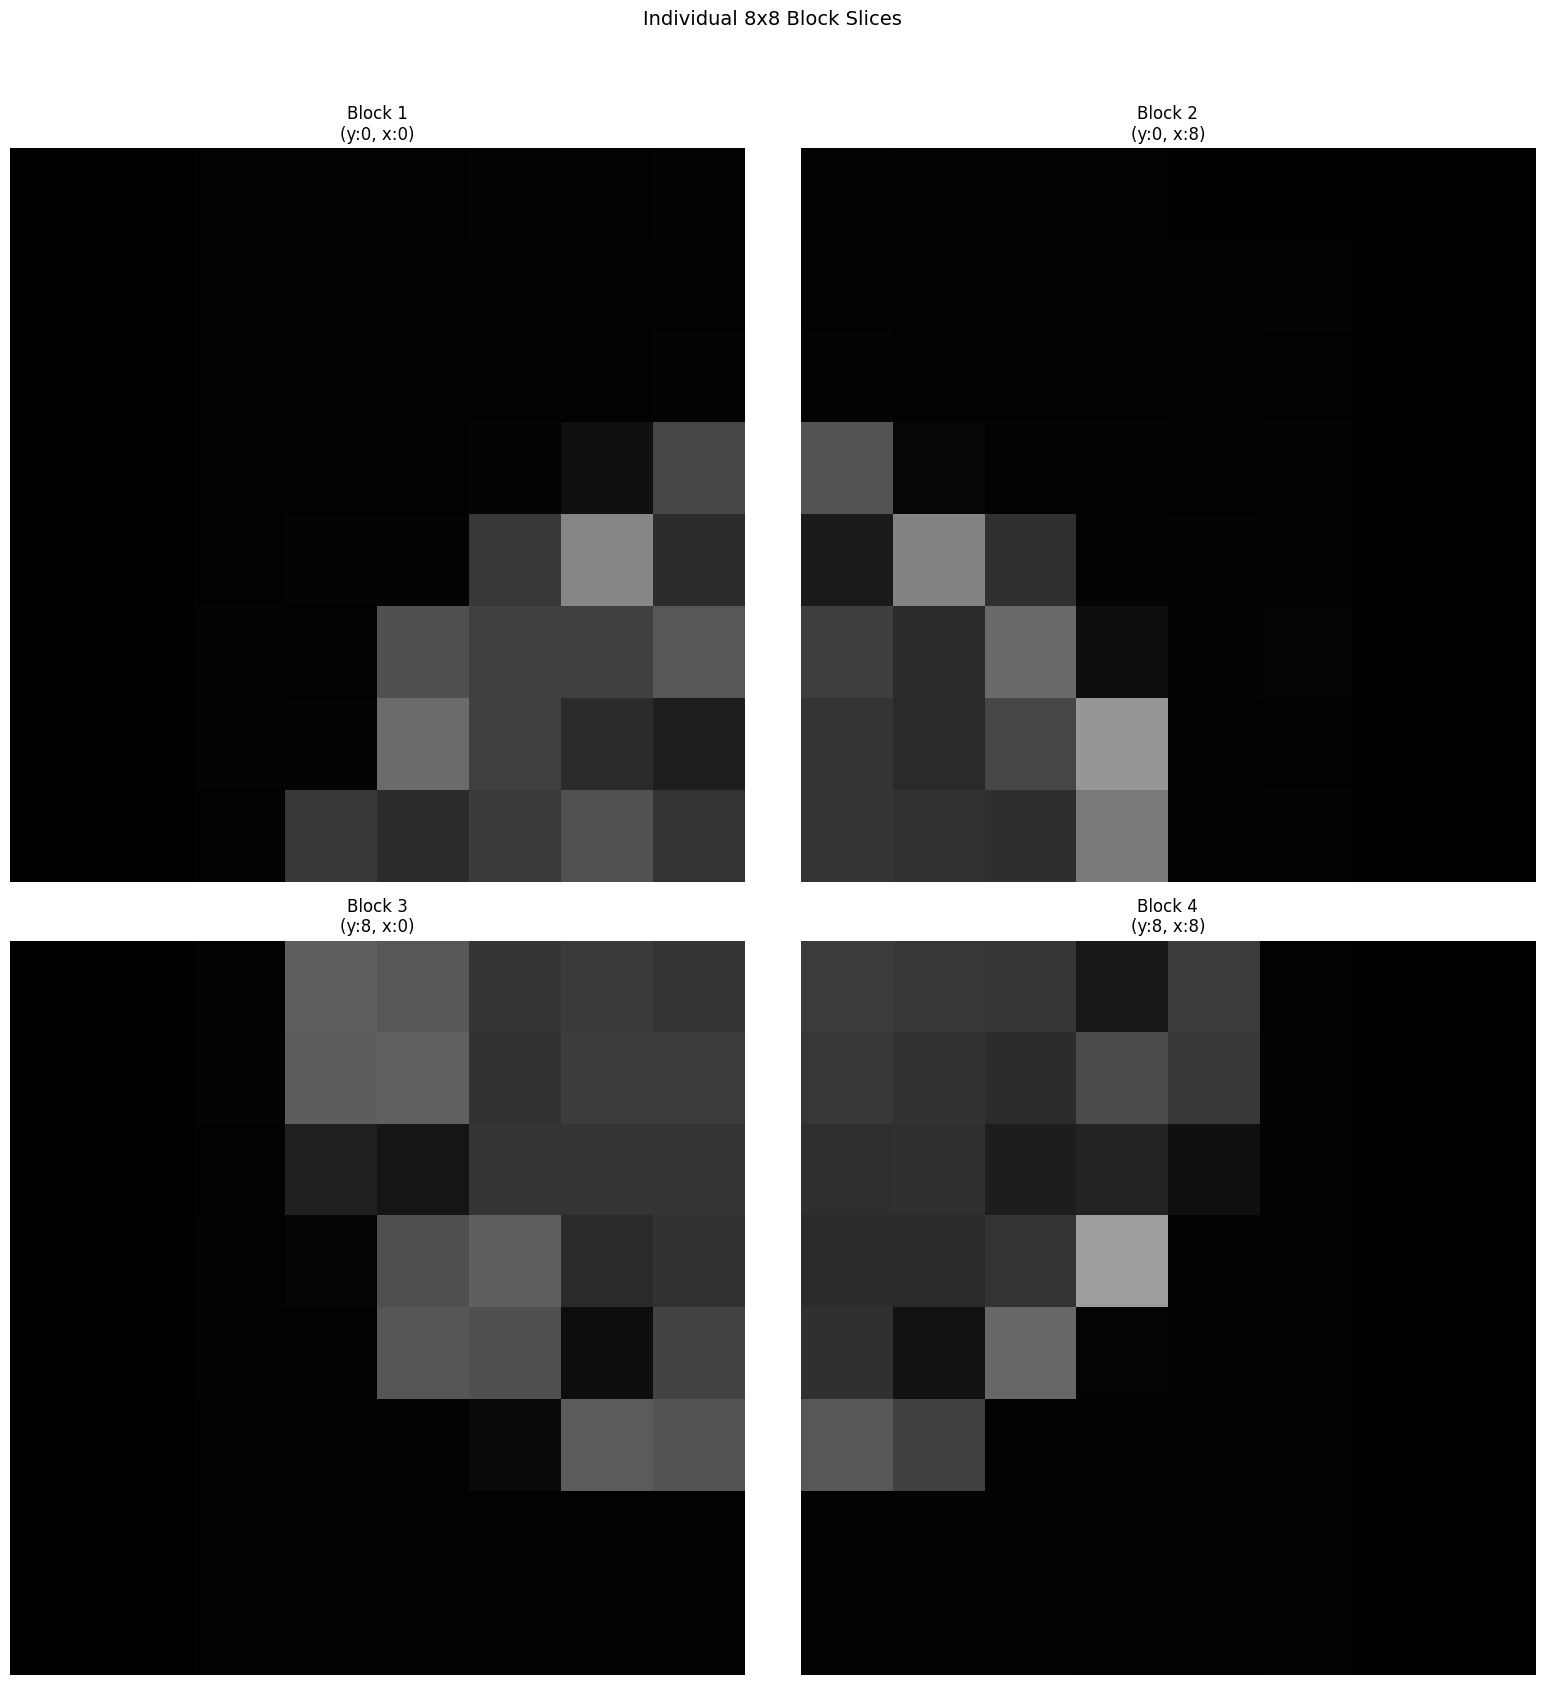

In [65]:
import matplotlib.pyplot as plt
import numpy as np


# Calculate number of blocks
blocks_per_side = IMG_SIZE // BLOCK_SIZE
total_blocks = blocks_per_side ** 2

# Create a figure to hold all sub-images
fig, axes = plt.subplots(blocks_per_side, blocks_per_side, figsize=(IMG_SIZE, IMG_SIZE))
axes = axes.flatten() # Flatten to iterate easily if grid is 2D

block_idx = 0
for y in range(0, IMG_SIZE, BLOCK_SIZE):
    for x in range(0, IMG_SIZE, BLOCK_SIZE):
        # Slice the individual 8x8 block
        block = img[y:y+BLOCK_SIZE, x:x+BLOCK_SIZE]
        
        # Plot in the corresponding subplot
        axes[block_idx].imshow(block, cmap='gray', vmin=0, vmax=255)
        axes[block_idx].set_title(f"Block {block_idx + 1}\n(y:{y}, x:{x})")
        axes[block_idx].axis('off')
        
        block_idx += 1

plt.tight_layout()
plt.suptitle(f"Individual {BLOCK_SIZE}x{BLOCK_SIZE} Block Slices", fontsize=14, y=1.05)
plt.show()

## Quantum-Chaotic key generation

In [50]:
# Cell: Key Generation
# Generate a long enough chaotic sequence for all blocks
x0 = qrng(SEED_BITS) / (2**SEED_BITS - 1)
y0 = qrng(SEED_BITS) / (2**SEED_BITS - 1)

# We need a sequence that covers the total number of pixels in the image
x_seq, y_seq = henon_map(x0, y0, n_iter=IMG_SIZE * IMG_SIZE)

# Ensure no NaN values from Henon map overflow
x_seq = np.nan_to_num(x_seq)
y_seq = np.nan_to_num(y_seq)

# Global keys to be sliced later
bpk_global = np.floor(x_seq * 256).astype(np.uint8)
ksk_global = np.floor(y_seq * 256).astype(np.uint8)

c:\Users\MANEESH M NAIR\Desktop\DUK\S4\Project\Quantum Image Encryption\chaos\henon.py:10: RuntimeWarning: overflow encountered in scalar power
  x[i] = 1 - alpha * (x[i-1] ** 2) + y[i-1]
C:\Users\MANEESH M NAIR\AppData\Local\Temp\ipykernel_31704\3687871740.py:14: RuntimeWarning: overflow encountered in multiply
  bpk_global = np.floor(x_seq * 256).astype(np.uint8)
C:\Users\MANEESH M NAIR\AppData\Local\Temp\ipykernel_31704\3687871740.py:14: RuntimeWarning: invalid value encountered in cast
  bpk_global = np.floor(x_seq * 256).astype(np.uint8)
C:\Users\MANEESH M NAIR\AppData\Local\Temp\ipykernel_31704\3687871740.py:15: RuntimeWarning: overflow encountered in multiply
  ksk_global = np.floor(y_seq * 256).astype(np.uint8)
C:\Users\MANEESH M NAIR\AppData\Local\Temp\ipykernel_31704\3687871740.py:15: RuntimeWarning: invalid value encountered in cast
  ksk_global = np.floor(y_seq * 256).astype(np.uint8)


## NEQR Encoding

In [51]:
# Cell: Block-wise Encryption
full_encrypted_img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
num_blocks_side = IMG_SIZE // BLOCK_SIZE
num_position_qubits = int(2 * np.log2(BLOCK_SIZE))

block_count = 0
for y in range(0, IMG_SIZE, BLOCK_SIZE):
    for x in range(0, IMG_SIZE, BLOCK_SIZE):
        # 1. Extract Block
        block = img[y:y+BLOCK_SIZE, x:x+BLOCK_SIZE]
        print(f"Processing Block at y:{y}, x:{x} | Shape: {block.shape}")
        
        # 2. Slice keys for this specific block
        # Using a slice of length BLOCK_SIZE for quantum operations
        current_bpk = bpk_global[block_count : block_count + BLOCK_SIZE]
        current_ksk = ksk_global[block_count : block_count + BLOCK_SIZE]
        
        # 3. Quantum Scrambling
        qc = encode_neqr(block)
        qc = quantum_scramble(qc, current_bpk, num_position_qubits)
        qc = quantum_permutation(qc, current_ksk, num_position_qubits)
        
        scrambled_block = reconstruct_neqr_image(qc, BLOCK_SIZE, BLOCK_SIZE, shots=SHOTS)
        
        # 4. DNA Encryption
        dni0, dni1, dni2, dni3 = dna_encode(scrambled_block, current_ksk)
        KH_block = generate_chaotic_key_image(BLOCK_SIZE, BLOCK_SIZE)
        dki0, dki1, dki2, dki3 = dna_encode(KH_block, current_ksk)
        
        # 5. XOR and Combine
        encrypted_block = (
            (dni0 ^ dki0) << 6 | (dni1 ^ dki1) << 4 | (dni2 ^ dki2) << 2 | (dni3 ^ dki3)
        ).astype(np.uint8)
        
        full_encrypted_img[y:y+BLOCK_SIZE, x:x+BLOCK_SIZE] = encrypted_block
        block_count += 1

Processing Block at y:0, x:0 | Shape: (8, 8)
Processing Block at y:0, x:8 | Shape: (8, 8)
Processing Block at y:8, x:0 | Shape: (8, 8)
Processing Block at y:8, x:8 | Shape: (8, 8)


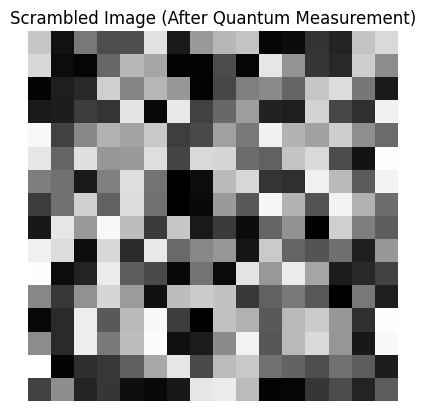

In [52]:
plt.imshow(full_encrypted_img, cmap="gray")
plt.title("Scrambled Image (After Quantum Measurement)")
plt.axis("off")
plt.show()

## Decryption and Reconstruction

In [53]:
# Cell: Block-wise Decryption
reconstructed_full_img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
block_count = 0 # Reset block counter to align with encryption keys

for y in range(0, IMG_SIZE, BLOCK_SIZE):
    for x in range(0, IMG_SIZE, BLOCK_SIZE):
        # 1. Extract Encrypted Block
        enc_block = full_encrypted_img[y:y+BLOCK_SIZE, x:x+BLOCK_SIZE]
        
        # 2. Slice keys using the SAME index as encryption
        current_bpk = bpk_global[block_count : block_count + BLOCK_SIZE]
        current_ksk = ksk_global[block_count : block_count + BLOCK_SIZE]
        
        # 3. DNA Decryption
        KH_block = generate_chaotic_key_image(BLOCK_SIZE, BLOCK_SIZE)
        dki0, dki1, dki2, dki3 = dna_encode(KH_block, current_ksk)
        # Use current_ksk to ensure the same DNA rules are applied
        scrambled_recovered = dna_decrypt(enc_block, dki0, dki1, dki2, dki3, current_ksk)
        
        # 4. Reverse Quantum Operations
        qc_re = encode_neqr(scrambled_recovered)
        qc_re = reverse_quantum_permutation(qc_re, current_ksk, num_position_qubits)
        qc_re = reverse_quantum_scrambling(qc_re, current_bpk, num_position_qubits)
        
        # 5. Final Reconstruction
        reconstructed_block = reconstruct_neqr_image(qc_re, BLOCK_SIZE, BLOCK_SIZE, shots=SHOTS)
        reconstructed_full_img[y:y+BLOCK_SIZE, x:x+BLOCK_SIZE] = reconstructed_block
        
        block_count += 1

c:\Users\MANEESH M NAIR\Desktop\DUK\S4\Project\Quantum Image Encryption\dna\dna_decode.py:48: RuntimeWarning: overflow encountered in scalar subtract
  DNi1[i, j] = (DNi1[i, j] - key) % 4
c:\Users\MANEESH M NAIR\Desktop\DUK\S4\Project\Quantum Image Encryption\dna\dna_decode.py:50: RuntimeWarning: overflow encountered in scalar subtract
  DNi2[i, j] = (DNi2[i, j] - key) % 4
c:\Users\MANEESH M NAIR\Desktop\DUK\S4\Project\Quantum Image Encryption\dna\dna_decode.py:46: RuntimeWarning: overflow encountered in scalar subtract
  DNi0[i, j] = (DNi0[i, j] - key) % 4
c:\Users\MANEESH M NAIR\Desktop\DUK\S4\Project\Quantum Image Encryption\dna\dna_decode.py:48: RuntimeWarning: overflow encountered in scalar subtract
  DNi1[i, j] = (DNi1[i, j] - key) % 4
c:\Users\MANEESH M NAIR\Desktop\DUK\S4\Project\Quantum Image Encryption\dna\dna_decode.py:52: RuntimeWarning: overflow encountered in scalar subtract
  DNi3[i, j] = (DNi3[i, j] - key) % 4
c:\Users\MANEESH M NAIR\Desktop\DUK\S4\Project\Quantum Image

## Quantitative Evaluation (PSNR & SSIM)

In [54]:
psnr_val, ssim_val = compute_psnr_ssim(img, reconstructed_full_img)

print("Shots :", SHOTS)
print(f"PSNR  : {psnr_val:.2f} dB")
print(f"SSIM  : {ssim_val:.4f}")


Shots : 65536
PSNR  : 6.10 dB
SSIM  : -0.0145


Original vs Reconstructed(decrypted)

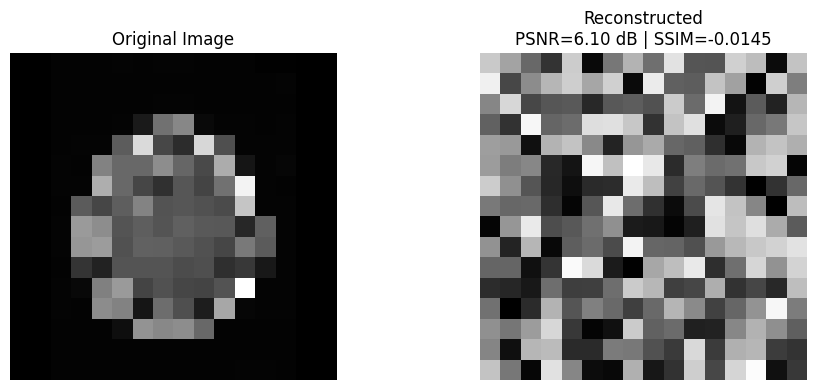

In [55]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(reconstructed_full_img, cmap="gray")
plt.title(f"Reconstructed\nPSNR={psnr_val:.2f} dB | SSIM={ssim_val:.4f}")
plt.axis("off")

plt.tight_layout()
plt.show()
